In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import category_encoders as ce

# Metrics and graphics libraries
from sklearn import metrics
import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the raw data
plays_df = pd.read_csv('/Users/JKMacBook/Documents/Lambda/Kaggle/NFL/nfl-big-data-bowl-2021/full_play_3.csv')

In [3]:
# Select features
df = plays_df[['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'defendersInTheBox',
               'numberOfPassRushers', 'preSnapVisitorScore', 'preSnapHomeScore',
               'manZone', 'scheme', 'route', 'endDist', 'covDist', 'closeSpeed', 'passResult']].copy()
df.head()

,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,manZone,scheme,route,endDist,covDist,closeSpeed,passResult
0,1,1,15,20,7.0,4.0,0.0,0.0,zone,cover-3,HITCH,2.957871,10.726609,4.369544,C
1,1,1,10,39,7.0,4.0,0.0,0.0,zone,cover-3,HITCH,1.891719,6.238350,4.909824,I
2,1,2,10,39,6.0,4.0,0.0,0.0,man,cover-1,NaN,NaN,NaN,NaN,I
3,1,3,10,39,6.0,5.0,0.0,0.0,man,cover-1,CORNER,3.898949,16.873620,5.341803,C
4,1,3,1,1,8.0,6.0,0.0,0.0,man,cover-0,GO,4.464135,5.517937,-3.789258,I


In [4]:
# Shape of the initial data
df.shape

(19239, 15)

In [5]:
# Drop all rows with Nan values
df = df[df['route'].notna()]
df = df[df['preSnapHomeScore'].notna()]
df = df[df['covDist'].notna()]
df.head()

,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,manZone,scheme,route,endDist,covDist,closeSpeed,passResult
0,1,1,15,20,7.0,4.0,0.0,0.0,zone,cover-3,HITCH,2.957871,10.726609,4.369544,C
1,1,1,10,39,7.0,4.0,0.0,0.0,zone,cover-3,HITCH,1.891719,6.238350,4.909824,I
3,1,3,10,39,6.0,5.0,0.0,0.0,man,cover-1,CORNER,3.898949,16.873620,5.341803,C
4,1,3,1,1,8.0,6.0,0.0,0.0,man,cover-0,GO,4.464135,5.517937,-3.789258,I
5,1,2,8,4,7.0,4.0,0.0,0.0,zone,cover-3,OUT,1.417956,5.406966,3.213817,C


In [6]:
# Shape after clean up
df.shape

(12937, 15)

In [7]:
# Encode target, Completions = 1, Incompletions, Interception and Sacks = 0
df['outcome'] = np.where(df['passResult'] == 'C', 1, 0)
df = df.drop(columns=['passResult'])
df.head()

,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,manZone,scheme,route,endDist,covDist,closeSpeed,outcome
0,1,1,15,20,7.0,4.0,0.0,0.0,zone,cover-3,HITCH,2.957871,10.726609,4.369544,1
1,1,1,10,39,7.0,4.0,0.0,0.0,zone,cover-3,HITCH,1.891719,6.238350,4.909824,0
3,1,3,10,39,6.0,5.0,0.0,0.0,man,cover-1,CORNER,3.898949,16.873620,5.341803,1
4,1,3,1,1,8.0,6.0,0.0,0.0,man,cover-0,GO,4.464135,5.517937,-3.789258,0
5,1,2,8,4,7.0,4.0,0.0,0.0,zone,cover-3,OUT,1.417956,5.406966,3.213817,1


In [8]:
# Split into train and test
train, test = train_test_split(df, test_size=0.2)

In [9]:
# Test data completions vs incompletions
test['outcome'].value_counts()

1    2089
0     499
Name: outcome, dtype: int64

In [10]:
# Encode and fit a Logistic Regression model
target = 'outcome'

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Create the pipeline
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                         LogisticRegression())

# Fit the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  26,  473],
       [  18, 2071]])

In [11]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8102782071097373
Precision: 0.8140723270440252
Recall: 0.9913834370512207


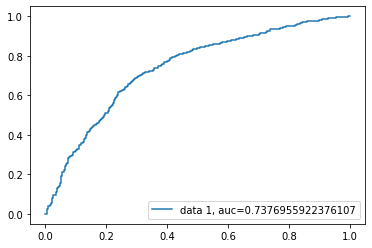

In [12]:
# Print the ROC curve
y_pred_proba = pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [13]:
# Obtain the feature coefficients
importance = pipeline.steps[1][1].coef_[0]
importance[0]

-0.09367126372202855

quarter  Score:  -0.09367126372202855
down  Score:  -0.08311221462250841
yardsToGo  Score:  -0.006851070516286868
yardlineNumber  Score:  0.0010751877614103708
defendersInTheBox  Score:  -0.00684018902413018
numberOfPassRushers  Score:  -0.01688335254512294
preSnapVisitorScore  Score:  0.004512509118308346
preSnapHomeScore  Score:  0.00563627683448386
manZone_zone  Score:  0.20312168384948046
manZone_man  Score:  0.23151662947798188
manZone_None  Score:  0.13482677788415356
scheme_cover-3  Score:  0.12913571265438173
scheme_cover-4  Score:  0.07398597119523825
scheme_cover-0  Score:  -0.13536509211109454
scheme_cover-1  Score:  0.18380190488917492
scheme_None  Score:  0.13482677788415356
scheme_cover-2  Score:  0.18307981669989296
route_SLANT  Score:  0.1859828418246271
route_CROSS  Score:  0.10901279171937861
route_OUT  Score:  0.19802171857333
route_SCREEN  Score:  0.7533210674673795
route_FLAT  Score:  0.005146011978967052
route_HITCH  Score:  0.3722051493952053
route_GO  Score:  -0

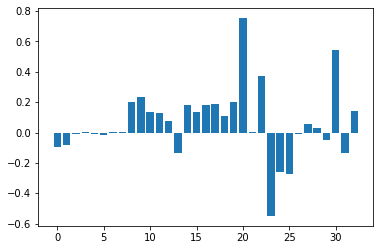

In [14]:
# Map the features to their coefficients
feature_names = pipeline.steps[0][1].get_feature_names()
for i in range(len(feature_names)):
    print(feature_names[i], ' Score: ', importance[i])
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()